In [4]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from os.path import join
import os
import seaborn as sns



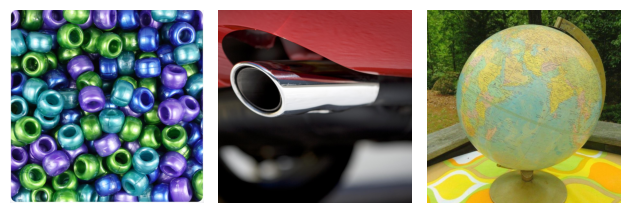

In [5]:
# First look at some of the images
dataset = '100_objects' # alternatively 100_faces or hm_IT
path2dataset = f'testsets/{dataset}'

listimages = os.listdir(path2dataset)
fig, subs = plt.subplots(1,3)
for i, img in enumerate(listimages[:3]):
    img = cv2.imread(join(path2dataset, img))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    subs[i].imshow(img)
    subs[i].axis('off')
fig.tight_layout()
plt.show()

In [9]:
## Dot product

def similarity_dotproduct(vectors):
    vectors_normalized = vectors / np.linalg.norm(vectors, axis=1, keepdims=True)
    # Compute similarity matrix (cosine similarity)
    similarity_matrix = np.dot(vectors_normalized, vectors_normalized.T)
    # Convert to dissimilarity: 1 - similarity
    return 1 - similarity_matrix

## L2 norm

from scipy.spatial.distance import pdist, squareform

def similarity_L2norm(vectors):
    vectors_normalized = vectors / np.linalg.norm(vectors, axis=1, keepdims=True)
    # Compute similarity matrix (l2 norm similarity)
    distances = pdist(vectors_normalized, 'euclidean')
    # Convert to dissimilarity: 1 - similarity
    return squareform(distances)

In [10]:
def compute_RDMs(model, dataset, listimages, display = True):
    path2activations = f'/data/alban/activations/{model}_{dataset}'
    cls_token = list()
    patch_token = list()
    for i, im in enumerate(listimages):
        cls_token.append(np.load(join(path2activations, f'cls_token_{im[:-4]}.npy')))
        #patch_token.append(np.load(join(path2activations, f'patch_token_{im[:-4]}.npy')))
    cls_token = np.array(cls_token)

    corr_cls = np.corrcoef(cls_token)
    #corr_patch = np.corrcoef(patch_token)

    l2_cls = similarity_L2norm(cls_token)
    #l2_patch = similarity_L2norm(patch_token)

    if display:
        fig, subs = plt.subplots(1,1)
        # Using a different colormap that goes from blue (similar) to red (dissimilar)
        sns.heatmap(1-corr_cls,
                    annot=False,
                    cmap='Greys',      # Blue to red colormap
                    square=True,
                    cbar=False,
                    #cbar_kws={'label': 'Dissimilarity'},
                    #fmt='.2f',
                    linewidths=0,
                    ax = subs,
                    vmin=0,               # Set minimum value for color scale
                    vmax=1)               # Set maximum value for color scale


        subs.set_title(f'Trained on {model} and tested on {dataset}')

        subs.axis('off')
        fig.tight_layout()
        plt.show()
        fig.savefig(f'figures/RDM_{model}_{dataset}.png', dpi=300, bbox_inches='tight')
        return corr_cls, l2_cls



['air_conditioner_air_conditioner_05s.jpg', 'air_mattress_air_mattress_04s.jpg', 'air_pump_air_pump_09s.jpg', 'airbag_airbag_08s.jpg', 'airplane_airplane_12n.jpg', 'album_album_05s.jpg', 'almond_almond_05s.jpg', 'aloe_aloe_11n.jpg', 'altar_altar_07s.jpg', 'aluminum_foil_aluminum_foil_08s.jpg', 'amber_amber_11s.jpg', 'amplifier_amplifier_13s.jpg', 'anchor_anchor_08s.jpg', 'antenna_antenna_07s.jpg', 'anvil_anvil_09s.jpg', 'apron_apron_11s.jpg', 'arrow_arrow_01b.jpg', 'ashtray_ashtray_07n.jpg', 'backgammon_backgammon_08s.jpg', 'backpack_backpack_06s.jpg', 'badge_badge_09s.jpg', 'basketball_basketball_02s.jpg', 'bat2_bat2_11s.jpg', 'battery_battery_12s.jpg', 'bead_bead_10s.jpg', 'block_block_09s.jpg', 'blowtorch_blowtorch_14n.jpg', 'board_game_board_game_17s.jpg', 'bolt_bolt_07n.jpg', 'boomerang_boomerang_05s.jpg', 'bouquet_bouquet_01b.jpg', 'bracket_bracket_10s.jpg', 'brick_brick_05s.jpg', 'briefcase_briefcase_01b.jpg', 'cable_cable_11s.jpg', 'cactus_cactus_02s.jpg', 'canvas_canvas_13s.jp

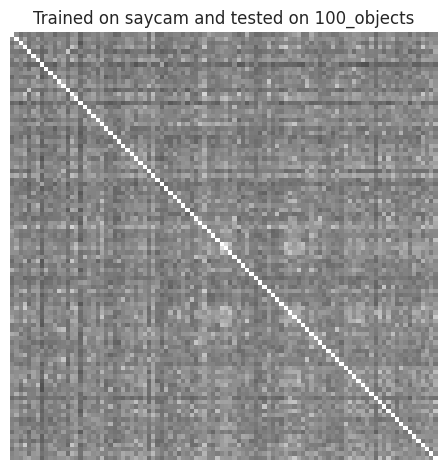

In [13]:
dataset = '100_objects' # alternatively 100_faces or hm_IT
path2dataset = f'testsets/{dataset}'
from natsort import natsorted

def sort_key(filename):
    # Split by underscore and extract number and letter
    parts = filename.split('_')
    if len(parts) >= 2:
        number = int(parts[0])  # First part is the number
        letter = parts[1][0]    # First character of second part is the letter
        return (letter, number)
    return (filename,)  # Fallback

listimages = os.listdir(path2dataset)
listimages = natsorted(listimages) # for hm_IT dataset or
#listimages = sorted(listimages, key=sort_key) #for 100_faces
print(listimages)

corr_saycam, l2_saycam = compute_RDMs('saycam', dataset, listimages)

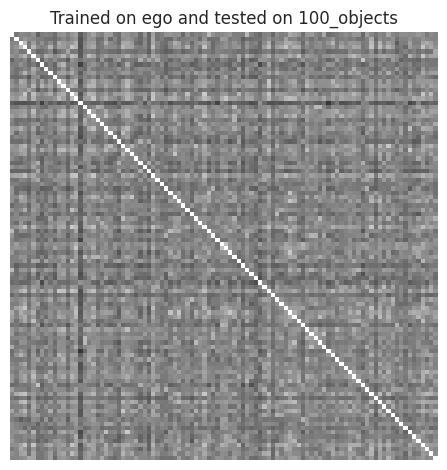

In [14]:
corr_ego, l2_ego = compute_RDMs('ego', dataset, listimages)


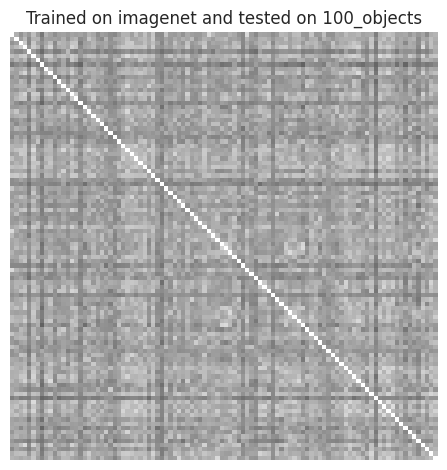

In [15]:
corr_imagenet, l2_imagenet = compute_RDMs('imagenet', dataset,  listimages)

In [16]:
def Compute_sim_RDMs(RDM1, RDM2):#
    '''
    Function to compute correlational similarity between 2 RDMs.
    Only considers the upper triangular part, excluding the diagonal
    '''
    # Extract upper triangular part (excluding diagonal)
    n = len(RDM1)
    if n != len(RDM2):
        print('RDMs are of different sizes')
    upper_indices = np.triu_indices(n, k=1)  # k=1 excludes diagonal
    upper_RDM1 = RDM1[upper_indices]
    upper_RDM2 = RDM2[upper_indices]

    # compute correlations
    return np.corrcoef(upper_RDM1, upper_RDM2)[0,1]


In [18]:
sim_saycam_ego = Compute_sim_RDMs(corr_saycam, corr_ego)
sim_saycam_imagenet = Compute_sim_RDMs(corr_saycam, corr_imagenet)
sim_imagenet_ego = Compute_sim_RDMs(corr_imagenet, corr_ego)

print(f'The correlation between saycam and ego is {sim_saycam_ego}.')
print(f'The correlation between saycam and imagenet is {sim_saycam_imagenet}.')
print(f'The correlation between imagenet and ego is {sim_imagenet_ego}.')


The correlation between saycam and ego is 0.6592455770890036.
The correlation between saycam and imagenet is 0.6792560662717053.
The correlation between imagenet and ego is 0.6174334107339338.


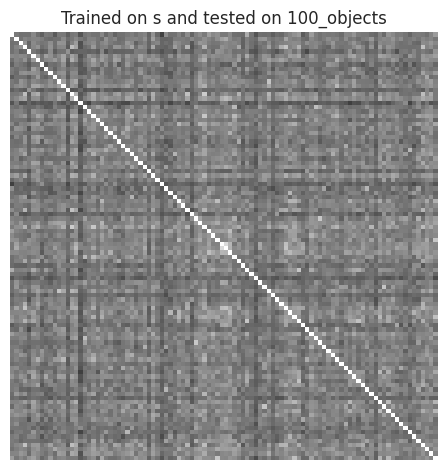

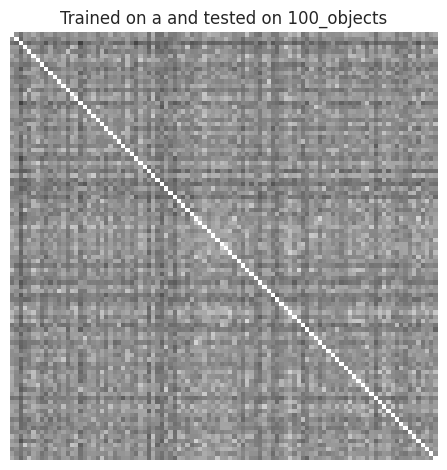

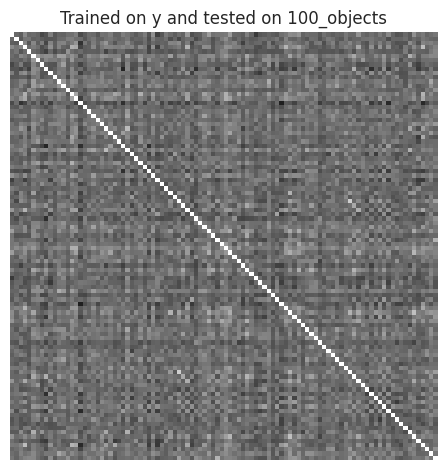

In [19]:
### Do the analysis for models trained individually on s, a and y.
corr_s, l2_s = compute_RDMs('s', dataset, listimages)
corr_a, l2_a = compute_RDMs('a', dataset, listimages)
corr_y, l2_y = compute_RDMs('y', dataset, listimages)


In [21]:
sim_s_a = Compute_sim_RDMs(corr_s, corr_a)
sim_s_y = Compute_sim_RDMs(corr_s, corr_y)
sim_a_y = Compute_sim_RDMs(corr_a, corr_y)

print(f'The correlation between s and a is {sim_s_a}.')
print(f'The correlation between s and y is {sim_s_y}.')
print(f'The correlation between a and y is {sim_a_y}.')

sim_say_s = Compute_sim_RDMs(corr_saycam, corr_s)
sim_say_a = Compute_sim_RDMs(corr_saycam, corr_a)
sim_say_y = Compute_sim_RDMs(corr_saycam, corr_y)

print(f'The correlation between say and s is {sim_say_s}.')
print(f'The correlation between say and a is {sim_say_a}.')
print(f'The correlation between say and y is {sim_say_y}.')


The correlation between s and a is 0.7151325764068299.
The correlation between s and y is 0.6421092022632766.
The correlation between a and y is 0.6576588724656174.
The correlation between say and s is 0.7983016423491733.
The correlation between say and a is 0.6973717708684176.
The correlation between say and y is 0.6312248323992401.


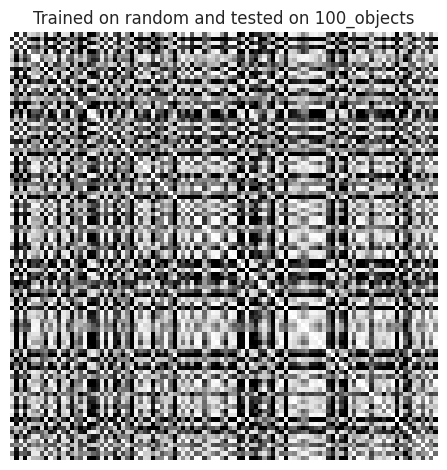

The correlation between say and s is 0.24165688480625624.
The correlation between ego and a is 0.25854634283395317.
The correlation between imagenet and y is 0.17157218501922572.


In [22]:
### Random model
### Do the analysis for models trained individually on s, a and y.
corr_random, l2_s = compute_RDMs('random', dataset, listimages)

sim_say_rand = Compute_sim_RDMs(corr_saycam, corr_random)
sim_ego_rand = Compute_sim_RDMs(corr_ego, corr_random)
sim_imagenet_rand = Compute_sim_RDMs(corr_imagenet, corr_random)

print(f'The correlation between say and s is {sim_say_rand}.')
print(f'The correlation between ego and a is {sim_ego_rand}.')
print(f'The correlation between imagenet and y is {sim_imagenet_rand}.')

In [47]:
### Work towards t-sne visualization

from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
from matplotlib.colors import ListedColormap
import warnings
warnings.filterwarnings('ignore')

def tsne_from_dissimilarity_matrix(dissimilarity_matrix, labels, size = 100,
                                 perplexity=30, n_iter=1000, random_state=42):
    """
    Create t-SNE visualization from dissimilarity matrix

    Parameters:
    - dissimilarity_matrix: 100x100 dissimilarity matrix
    - labels: list/array of labels for the 100 images
    - perplexity: t-SNE perplexity parameter
    - n_iter: number of iterations
    - random_state: random seed for reproducibility
    """

    # Ensure dissimilarity matrix is symmetric and valid
    print(dissimilarity_matrix.shape)
    assert dissimilarity_matrix.shape == (size, size), "Matrix must be 100x100"
    assert len(labels) == size, "Must have 100 labels"


    # Run t-SNE with precomputed distances
    tsne = TSNE(n_components=2,
                metric='precomputed',
                perplexity=perplexity,
                max_iter=n_iter,
                random_state=random_state,
                init='random')

    # Fit and transform
    tsne_results = tsne.fit_transform(dissimilarity_matrix)

    return tsne_results

def plot_tsne_results(tsne_results, labels, figsize=(6, 4.5),
                     title="t-SNE Visualization of Image Dissimilarity"):
    """
    Plot t-SNE results with colored labels
    """
    # Encode labels to numbers for coloring
    le = LabelEncoder()
    label_encoded = le.fit_transform(labels)
    unique_labels = le.classes_

    # Create figure
    plt.figure(figsize=figsize)

    # Create scatter plot
    scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1],
                         c=label_encoded, cmap='autumn',
                         alpha=0.7, s=50)

    # Add labels and title
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xlabel('t-SNE Component 1', fontsize=12)
    plt.ylabel('t-SNE Component 2', fontsize=12)

    # Add legend
    handles = [plt.Line2D([0], [0], marker='o', color='w',
                         markerfacecolor=scatter.cmap(scatter.norm(i)),
                         markersize=8, label=unique_labels[i])
               for i in range(len(unique_labels))]
    plt.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc='upper left')

    # Add grid
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    return plt.gcf()

def analyze_clusters(tsne_results, labels):
    """
    Analyze cluster quality and separation
    """
    from sklearn.metrics import silhouette_score
    from sklearn.preprocessing import LabelEncoder

    le = LabelEncoder()
    label_encoded = le.fit_transform(labels)

    # Calculate silhouette score
    sil_score = silhouette_score(tsne_results, label_encoded)

    print(f"Silhouette Score: {sil_score:.3f}")
    print(f"Number of unique labels: {len(np.unique(labels))}")

    # Label distribution
    unique, counts = np.unique(labels, return_counts=True)
    print("\nLabel distribution:")
    for label, count in zip(unique, counts):
        print(f"  {label}: {count} images")

    return sil_score

# Example usage and complete pipeline
def complete_tsne_pipeline(dissimilarity_matrix, labels, title):
    """
    Complete example with synthetic data
    """

    print("Running t-SNE on dissimilarity matrix...")

    # Run t-SNE
    tsne_results = tsne_from_dissimilarity_matrix(dissimilarity_matrix, labels, size = len(dissimilarity_matrix))

    # Plot results
    fig = plot_tsne_results(tsne_results, labels, title = title)
    plt.show()

    # Analyze clusters
    analyze_clusters(tsne_results, labels)


    return tsne_results, labels



(100, 100)
Running t-SNE on dissimilarity matrix...
(100, 100)


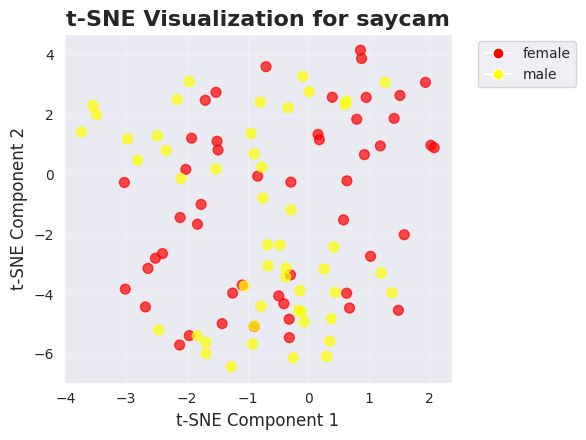

Silhouette Score: 0.008
Number of unique labels: 2

Label distribution:
  female: 50 images
  male: 50 images
Running t-SNE on dissimilarity matrix...
(100, 100)


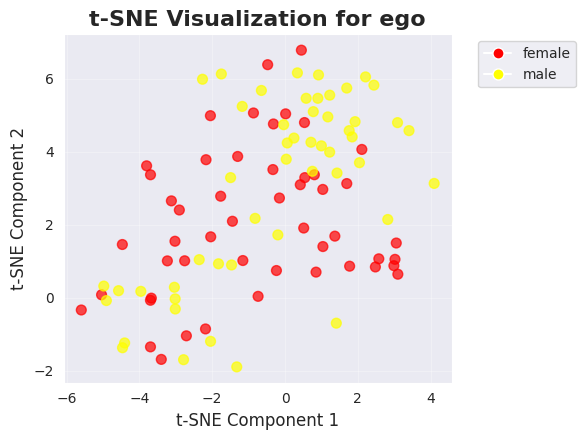

Silhouette Score: 0.041
Number of unique labels: 2

Label distribution:
  female: 50 images
  male: 50 images
Running t-SNE on dissimilarity matrix...
(100, 100)


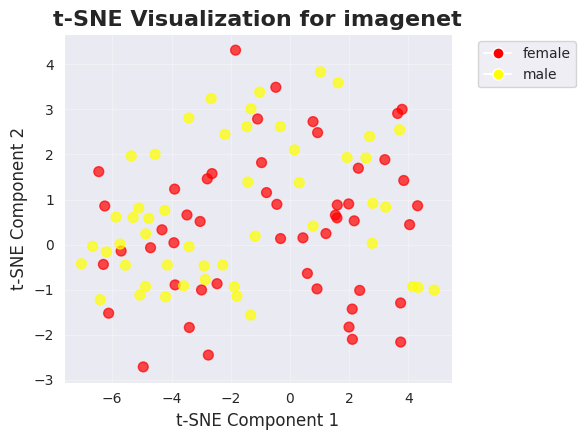

Silhouette Score: 0.024
Number of unique labels: 2

Label distribution:
  female: 50 images
  male: 50 images
Running t-SNE on dissimilarity matrix...
(100, 100)


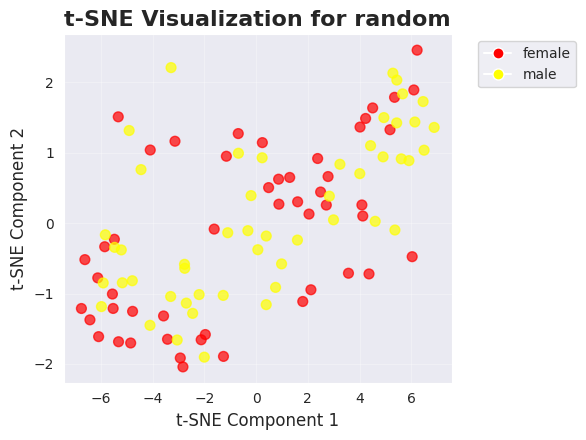

Silhouette Score: -0.004
Number of unique labels: 2

Label distribution:
  female: 50 images
  male: 50 images


In [53]:
# Main execution
from scipy.io import loadmat
# load metadata and get labels
metadata = loadmat('/raid/katha/datasets/faces_1000/test/metadata_male.mat')
### not sure what to do with it to be honest

labels1 = ['female' if i<50 else 'male' for i in range(100)]  # Animacy
print(corr_ego.shape)
# For demonstration, run with synthetic data
title = "t-SNE Visualization for saycam"
tsne_results, labels = complete_tsne_pipeline(1 - corr_saycam, labels1, title)

title = "t-SNE Visualization for ego"
tsne_results, labels = complete_tsne_pipeline(1 - corr_ego, labels1, title)

title = "t-SNE Visualization for imagenet"
tsne_results, labels = complete_tsne_pipeline(1 - corr_imagenet, labels1, title)

title = "t-SNE Visualization for random"
tsne_results, labels = complete_tsne_pipeline(1 - corr_random, labels1, title)
